In [37]:
################################
# Scientific imports
################################
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries

################################
# General imports
################################
import csv, math, io, os, os.path, sys, random, time
import pandas as pd
import seaborn as sb
from tqdm.notebook import tqdm, trange

################################
# SciKitLearn Imports
################################
import sklearn
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from IPython.display import display

################################
# MatPlotLib Settings
################################
plt.rcParams["figure.figsize"] = (20,9)
sb.set()

In [85]:
# Load the Data files
fitsarr = np.load("fitslist.npy")
fluxarr = np.load("fluxlist.npy")
planetarr = np.load("planetlist.npy")
isplanetarr = [1 if x==True else 0 for x in np.load("isplanetlist.npy")]

In [120]:
def GetLC(rndFile=-1, fullOutput=False):
    
    # rndFile is random, unless specified
    rndFile = random.randint(0,len(fitsarr)) if rndFile==-1 else rndFile
    #print("Curve = {}".format(rndFile))
    
    # Get LC data from the requisite fits file
    fitsFile = fitsarr[rndFile]

    # The following line of code gives us the header values
    fitsHeaders = fits.getheader(fitsFile)

    with fits.open(fitsFile, mode="readonly") as hdulist:

        # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
        # and TESS magnitude.
        #star_teff = hdulist[0].header['TEFF']
        #star_logg = hdulist[0].header['LOGG']
        #star_tmag = hdulist[0].header['TESSMAG']
        obj       = hdulist[0].header['OBJECT']
        #sector    = hdulist[0].header['SECTOR']

        # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
        # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
        # model fluxes.
        tess_bjds     = hdulist[1].data['TIME']
        #sap_fluxes    = hdulist[1].data['SAP_FLUX']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

    # X- and Y- labels
    ylab = "PDCSAP Flux (e-/s)"
    xlab = "Time (TBJD)"

    #plt.plot(tess_bjds, pdcsap_fluxes, markersize=1)
    #ax.plot(tess_bjds, pdcsap_fluxes, 'k.', markersize=1)
    if (fullOutput == True):
        return (tess_bjds, pdcsap_fluxes, str(rndFile), str(obj), ylab, xlab)
    else:
        return (tess_bjds, pdcsap_fluxes)
    #return (tess_bjds[1:-1], pdcsap_fluxes[1:-1], str(rndFile), str(obj), str(sector), ylab, xlab)

In [121]:
def DrawLC(n=-1, trimends=True):
    x,y,f,o,ylab,xlab = GetLC(n, fullOutput=True)

    fig, ax = plt.subplots()
    
    if (trimends):
        # Trims off the preceeding and proceeding zeroes present in the test data
        x = x[1:-1]
        y = y[1:-1]
        
    ax.plot(x,y)

    fig.suptitle("File № {} - {}".format(f, o), fontsize=20) # + str(obj) + " - Sector " + str(sector))

    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)

In [248]:
def FTTMyData(x,y):
    """
    Function that takes in a timeseries and then outputs a Fourier Transformed version of it
    """
    
    # First, change all 0s to NANs
    #ynew = [idx for idx, element in enumerate(y) if element == 0]
    #y[y==0] = np.nan
    
    # Is this required?
    TMP = np.correlate(y-np.mean(y),y-np.mean(y),mode='full')
    
    # FOURIER TRANSFORM THAT Y (remember to use np.nanmean instead of np.mean)
    FTY = np.fft.fft(y-np.mean(y))
    powSpectrum = np.abs(FTY)
    
    # Get Delta D
    delta_d = np.nanmean(np.diff(x))
    #print(delta_d)
    
    # DO THE THING
    F=np.fft.fftfreq(len(y),delta_d)
    #plt.plot(F,powSpectrum)
    return(F,powSpectrum)

In [79]:
def GetPositiveRates(dataArr, checkArr, param_grid):
    
    # Make a PCA Pipeline
    pca = PCA(svd_solver='randomized', n_components=8, whiten=True, random_state=42) # Number of components is something to be discussed
    svc = SVC(kernel='rbf', class_weight='balanced')
    model = make_pipeline(pca, svc)
    
    # Sort data into Test and Train
    Xtrain, Xtest, ytrain, ytest = train_test_split(dataArr, isplanetarrbin, random_state=42)
    
    # Do gridsearch for svc params
    grid = GridSearchCV(model, param_grid)
    
    # Fit model
    grid.fit(Xtrain, ytrain)
    
    # Use svc params and predict    
    model = grid.best_estimator_
    yfit = model.predict(Xtest)

    # Use PCA transform on Xtrain --- I don't quite know what this does but it seems to make things work so wahey!
    #pca.transform(Xtrain)
    
    # Now that model has done, time for confusion matrix shenanigans
    mat = confusion_matrix(ytest, yfit)
    TPR, FPR = ConfusionMatrix(mat)
    
    return (mat)

In [321]:
def ConfusionMatrix(mat):
    # CHECK IF SQUARE
    if (all (len (row) == len (mat) for row in mat)):
        TP = mat[0][0]  
        FP = mat[1][0]  
        TN = mat[1][1]  
        FN = mat[0][1]

        TPR = TP/(TP+FN)
        FPR = FP/(FP+TN)
        
        outputtext=\
"True Positives:  {}\n\
False Positives: {}\n\
True Negatives:  {}\n\
False Negatives: {}\n\
\n\
True Positive Rate:  {}\n\
False Positive Rate: {}\n"\
        .format(TP,FP,TN,FN,TPR,FPR)
        
        print(outputtext)
        
        return (outputtext,TPR,FPR)

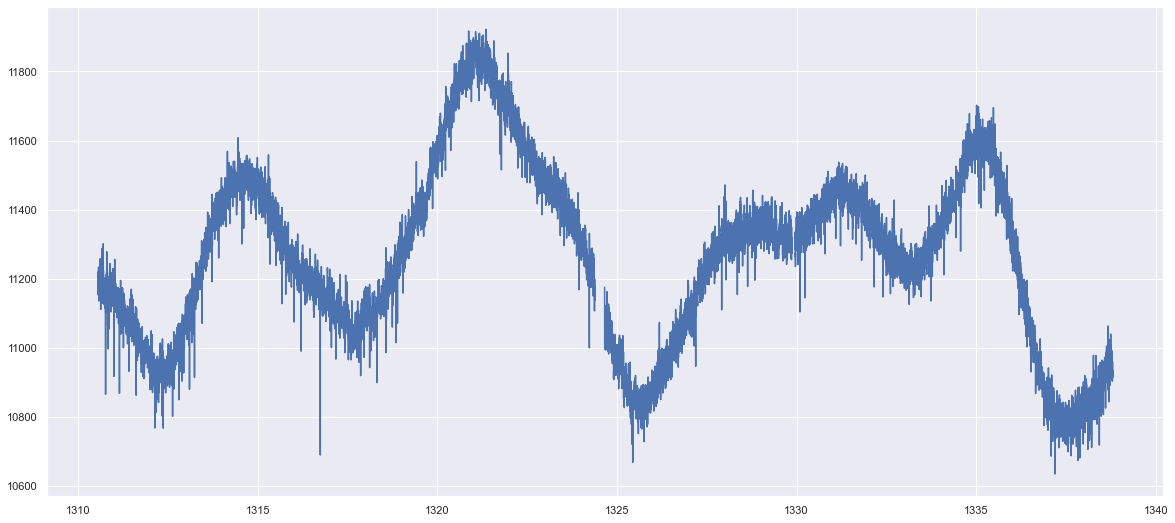

In [30]:
x,y = GetLC()

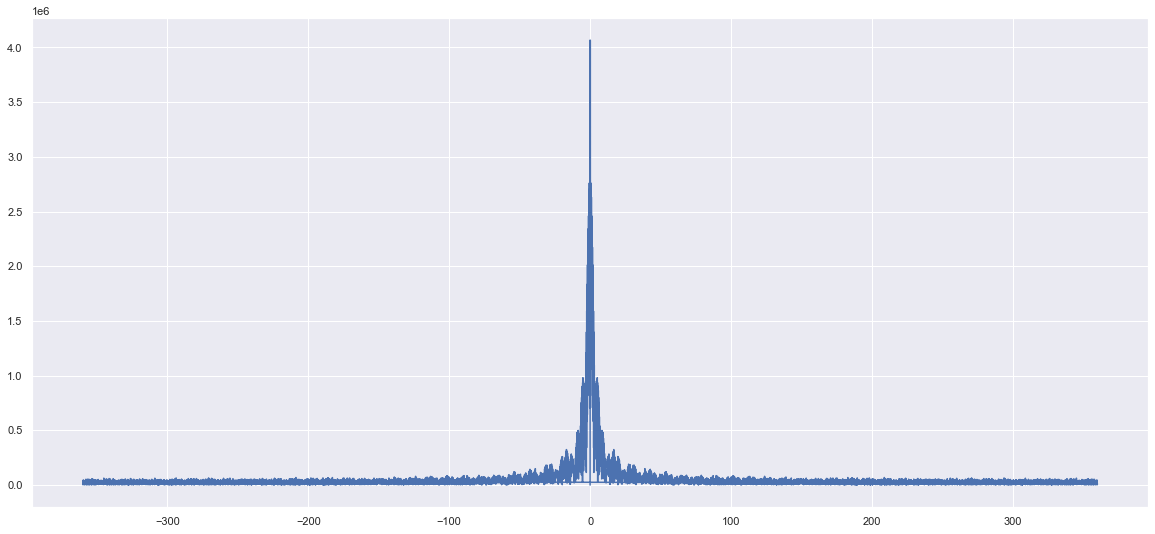

In [175]:
xFTT, yFTT = FTTMyData(x,y)

In [35]:
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}

In [46]:
confMat, truPosRate2, falPosRate2 = GetPositiveRates(fluxarr, isplanetarr, param_grid)

In [47]:
confMat

array([[3158,   99],
       [ 717,   26]])

Text(469.88, 0.5, 'Predicted Value')

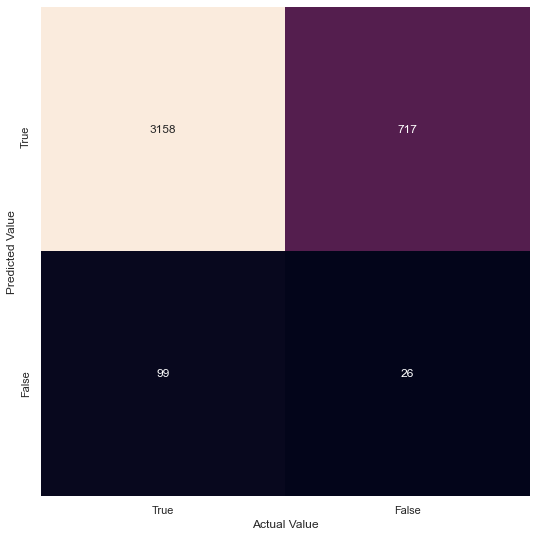

In [49]:
sb.heatmap(confMat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['True','False'],
            yticklabels=['True','False'])
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')

In [322]:
confRates = ConfusionMatrix(confMat)

True Positives:  3158
False Positives: 717
True Negatives:  26
False Negatives: 99

True Positive Rate:  0.9696039299969297
False Positive Rate: 0.9650067294751009



In [324]:
confRates[0]

'True Positives:  3158\nFalse Positives: 717\nTrue Negatives:  26\nFalse Negatives: 99\n\nTrue Positive Rate:  0.9696039299969297\nFalse Positive Rate: 0.9650067294751009\n'

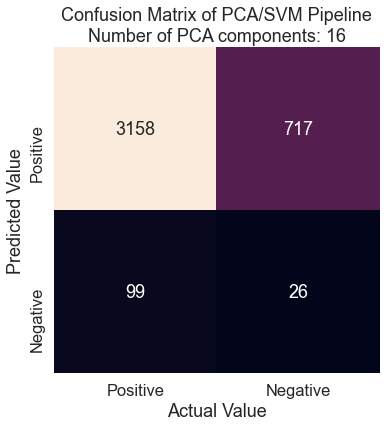

In [390]:
def PlotConfusionMatrix(mat):
    cMat  = sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Positive','Negative'],
            yticklabels=['Positive','Negative'])
    
    plt.rcParams["figure.figsize"] = (6,6)
    sb.set(font_scale=1.5)
    
    fig = cMat.get_figure() 
    plt.xlabel('Actual Value')
    plt.ylabel('Predicted Value')
    plt.title("Confusion Matrix of PCA/SVM Pipeline\nNumber of PCA components: {}".format(16))
    
    #plt.text(0,3.5,confRates[0])
    
    targetdest="./confusionmatrices/"
    
    plt.savefig(targetdest+"PCA_SVM_Matrix.png")
    
    with open(targetdest+"PCA_SVM_Matrix.txt", "w") as f:
        f.write(confRates[0])
        
    
PlotConfusionMatrix(confMat)

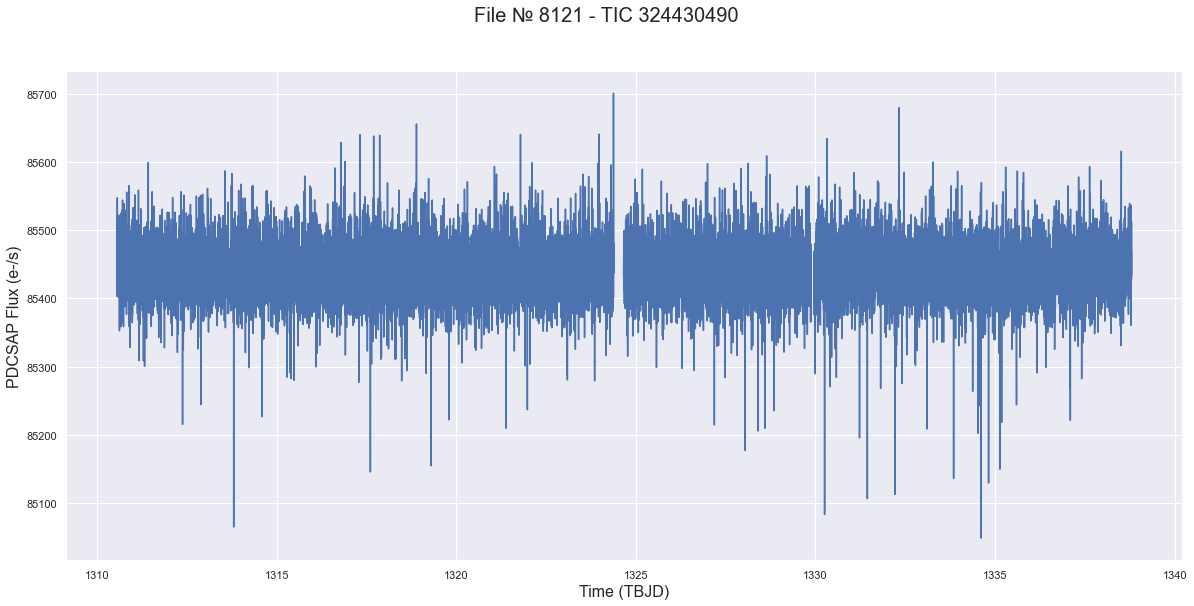

In [171]:
DrawLC()

In [249]:
def MakeFTTFile(inputarr):
    # Steps:
        # 1: Need the fluxlist.npy
        # 2: Make a new list of equal length
        # 3: For each item in fluxlist, get X and Y list
        # 4: FTT x and y
        # 5: Store new FFTx and FFTy (tuple?) in the corresponding index in new list
    ln = len(inputarr)
    eln = len(inputarr[0])
    print(ln)
    fttarr = np.zeros((ln,eln))
    print(len(fttarr))
    
    for n in range(len(fttarr)):
        # n is index, from 0 to len(inputarr)
        # flux is the actual list of fluxes
        x,y = GetLC(n)
        xFTT, yFTT = FTTMyData(x,y)
        fttarr[n] = yFTT
        #print("n = {0}; fttarr[{0}] = {1}".format(n,fttarr[n]))
        
    np.save("fourierfluxlist.npy",fttarr)
    print("Done!")

In [250]:
MakeFTTFile(fluxarr)

16000
16000
Done!
